In [1]:
import os
import pandas as pd
import torch
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models



#Neural Network

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy


#Ignore Warning

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def load_dataset():
    data_dir = 'data/'
    
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
    class_names = image_datasets['train'].classes
    
    
    return dataloaders, class_names, dataset_sizes
    
    

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


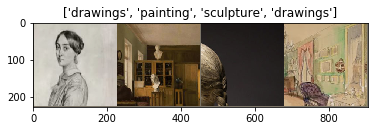

In [4]:
#Function to visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
dataloaders, class_names, dataset_sizes = load_dataset()
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            dataloaders, class_names, dataset_sizes = load_dataset()
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    dataloaders, class_names, dataset_sizes = load_dataset()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:


class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(512, 512, 3 ,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.fc = nn.Linear(512, 5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
model1 = ConvNet(5)

model = torch.nn.Sequential(
          torch.nn.Linear(512, 512),
          torch.nn.ReLU(),
          torch.nn.Linear(512, 512),
        ).to(device)


model_ft = models.resnet18(pretrained=True)
#print(model_ft)
removed = nn.Sequential(*list(model_ft.children())[:-2])

#print(model)
model_ft = nn.Sequential(removed, model1)

print(model_ft)
    

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [8]:

        
feature_extract = True




#Send the model to GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()


print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)




Params to learn:
	 0.0.weight
	 0.1.weight
	 0.1.bias
	 0.4.0.conv1.weight
	 0.4.0.bn1.weight
	 0.4.0.bn1.bias
	 0.4.0.conv2.weight
	 0.4.0.bn2.weight
	 0.4.0.bn2.bias
	 0.4.1.conv1.weight
	 0.4.1.bn1.weight
	 0.4.1.bn1.bias
	 0.4.1.conv2.weight
	 0.4.1.bn2.weight
	 0.4.1.bn2.bias
	 0.5.0.conv1.weight
	 0.5.0.bn1.weight
	 0.5.0.bn1.bias
	 0.5.0.conv2.weight
	 0.5.0.bn2.weight
	 0.5.0.bn2.bias
	 0.5.0.downsample.0.weight
	 0.5.0.downsample.1.weight
	 0.5.0.downsample.1.bias
	 0.5.1.conv1.weight
	 0.5.1.bn1.weight
	 0.5.1.bn1.bias
	 0.5.1.conv2.weight
	 0.5.1.bn2.weight
	 0.5.1.bn2.bias
	 0.6.0.conv1.weight
	 0.6.0.bn1.weight
	 0.6.0.bn1.bias
	 0.6.0.conv2.weight
	 0.6.0.bn2.weight
	 0.6.0.bn2.bias
	 0.6.0.downsample.0.weight
	 0.6.0.downsample.1.weight
	 0.6.0.downsample.1.bias
	 0.6.1.conv1.weight
	 0.6.1.bn1.weight
	 0.6.1.bn1.bias
	 0.6.1.conv2.weight
	 0.6.1.bn2.weight
	 0.6.1.bn2.bias
	 0.7.0.conv1.weight
	 0.7.0.bn1.weight
	 0.7.0.bn1.bias
	 0.7.0.conv2.weight
	 0.7.0.bn2.weight
	

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 1.3147 Acc: 0.4711
val Loss: 1.0066 Acc: 0.5853

Epoch 1/24
----------
train Loss: 1.2142 Acc: 0.5126
val Loss: 0.9230 Acc: 0.6250

Epoch 2/24
----------
train Loss: 1.1356 Acc: 0.5556
val Loss: 0.8188 Acc: 0.7255

Epoch 3/24
----------
train Loss: 1.0399 Acc: 0.6077
val Loss: 0.7889 Acc: 0.7348

Epoch 4/24
----------
train Loss: 0.9644 Acc: 0.6370
val Loss: 0.7580 Acc: 0.7547

Epoch 5/24
----------
train Loss: 0.8902 Acc: 0.6731
val Loss: 0.7104 Acc: 0.7371

Epoch 6/24
----------
train Loss: 0.8473 Acc: 0.6895
val Loss: 0.5969 Acc: 0.7874

Epoch 7/24
----------
train Loss: 0.7417 Acc: 0.7296
val Loss: 0.5509 Acc: 0.8014

Epoch 8/24
----------
train Loss: 0.6879 Acc: 0.7482
val Loss: 0.5365 Acc: 0.8026

Epoch 9/24
----------
train Loss: 0.6749 Acc: 0.7513
val Loss: 0.5273 Acc: 0.8189

Epoch 10/24
----------
train Loss: 0.6529 Acc: 0.7635
val Loss: 0.5196 Acc: 0.8014

Epoch 11/24
----------
train Loss: 0.6436 Acc: 0.7667
val Loss: 0.5403 Acc: 0.8096

Ep

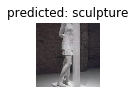

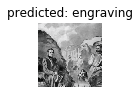

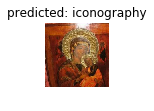

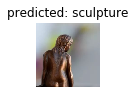

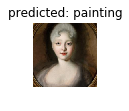

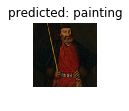

In [10]:
visualize_model(model_ft)

In [11]:
print(model_ft)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel